In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.integrate import solve_ivp
from scipy.optimize import minimize


### Example of a multiresponse parameter estimation using compartment models.

*Data for the oil shale pyrolysis obtained from "A Thermal Decomposition Study of Colorodo Oil Shale,"Hubberd, A.B. and Robinson, W.E., U.S. Bureau of Mines, Rept. Invest. No. 4744, 1950.*

### Estimating Parameters in Compartment Models

    Several methods can be used to estimate parameters in compartment models. The most obvious is to obtain the analytic solution to the system of differential equations and then use the expectation function corresponding to the compartment for which data is available in a standard non-linear estimation program.
   
    A second approach, *which is the one adopted in our example*, is to use a standard non-linear estimation program, but calculate the function by solving the equations using numerical integration.
    
    A third approach (Anderson, 1983) is to recognize that the responses (i.e., γ1, γ2, ... , γk) generally consist of weighted sums of exponential functions of time, with the exponents related to the system rate constants θ.

In [2]:
# time is measured in minutes and concentration of Bitumen & Oil is dimensionless (%)
df1 = pd.DataFrame()
df1["time_673_K"] = [5.0, 7.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0, 80.0, 100.0, 120.0, 150.0]
df1["Bitumen_673_K"] = [0.0, 2.2, 11.5, 13.7, 15.1, 17.3, 17.3, 20.1, 20.1, 22.3, 20.9, 11.5, 6.5, 3.6]
df1["Oil_673_K"] = [0.0, 0.0, 0.7, 7.2, 11.5, 15.8, 20.9, 26.6, 32.4, 38.1, 43.2, 49.6, 51.8, 54.7]

df2 = pd.DataFrame()
df2["time_698_K"] = [5.0, 7.0, 10.0, 12.5, 15.0, 17.5, 20.0, 25.0, 30.0, 40.0, 50.0, 60.0]
df2["Bitumen_698_K"] = [6.5, 14.4, 18.0, 16.5, 29.5, 23.7, 36.7, 27.3, 16.5, 7.2, 3.6, 2.2]
df2["Oil_698_K"] = [0.0, 1.4, 10.8, 14.4, 21.6, 30.2, 33.1, 40.3, 47.5, 55.4, 56.8, 59.7]

# 2 values are removed to not have duplicates in the regressor array
df3 = pd.DataFrame()
df3["time_723_K"] = [5.0, 7.5, 8.0, 9.0, 10.0, 11.0, 12.5, 15.0, 17.5, 17.6, 20.0, 20.1]
df3["Bitumen_723_K"] = [8.6, 15.8, 25.9, 25.2, 26.6, 33.8, 25.9, 20.1, 12.9, 9.3, 3.6, 2.2]
df3["Oil_723_K"] = [0.0, 2.9, 16.5, 24.4, 29.5, 35.2, 39.5, 45.3, 43.1, 54.6, 59.7, 53.9]

df4 = pd.DataFrame()
df4["time_748_K"] = [3.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 8.0, 9.0, 10.0, 12.5, 15.0]
df4["Bitumen_748_K"] = [0.7, 17.3, 23.0, 24.4, 23.0, 33.1, 31.6, 20.9, 10.1, 4.3, 0.7, 0.7]
df4["Oil_748_K"] = [0.0, 2.9, 17.3, 20.9, 25.9, 29.5, 33.8, 45.3, 53.2, 58.2, 57.5, 61.1]

df5 = pd.DataFrame()
df5["time_773_K"] = [3.0, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 10.0]
df5["Bitumen_773_K"] = [6.5, 24.4, 26.6, 25.9, 17.3, 21.6, 1.4, 0.0]
df5["Oil_773_K"] = [0.0, 23.0, 32.4, 37.4, 45.3, 45.3, 57.5, 60.4]

df6 = pd.DataFrame()
df6["time_798_K"] = [3.0, 3.25, 3.5, 4.0, 5.0, 7.0]
df6["Bitumen_798_K"] = [25.2, 33.1, 21.6, 20.9, 4.3, 0.0]
df6["Oil_798_K"] = [20.9, 25.2, 17.3, 36.7, 56.8, 61.8]

In [3]:
# creating arrays for regressors and responses variables at each temperature
regr_673 = df1["time_673_K"].values
responses_673 = df1.iloc[:, 1:].T.values

regr_698 = df2["time_698_K"].values
responses_698 = df2.iloc[:, 1:].T.values

regr_723 = df3["time_723_K"].values
responses_723 = df3.iloc[:, 1:].T.values

regr_748 = df4["time_748_K"].values
responses_748 = df4.iloc[:, 1:].T.values

regr_773 = df5["time_773_K"].values
responses_773 = df5.iloc[:, 1:].T.values

regr_798 = df6["time_798_K"].values
responses_798 = df6.iloc[:, 1:].T.values

### Preliminary Analysis

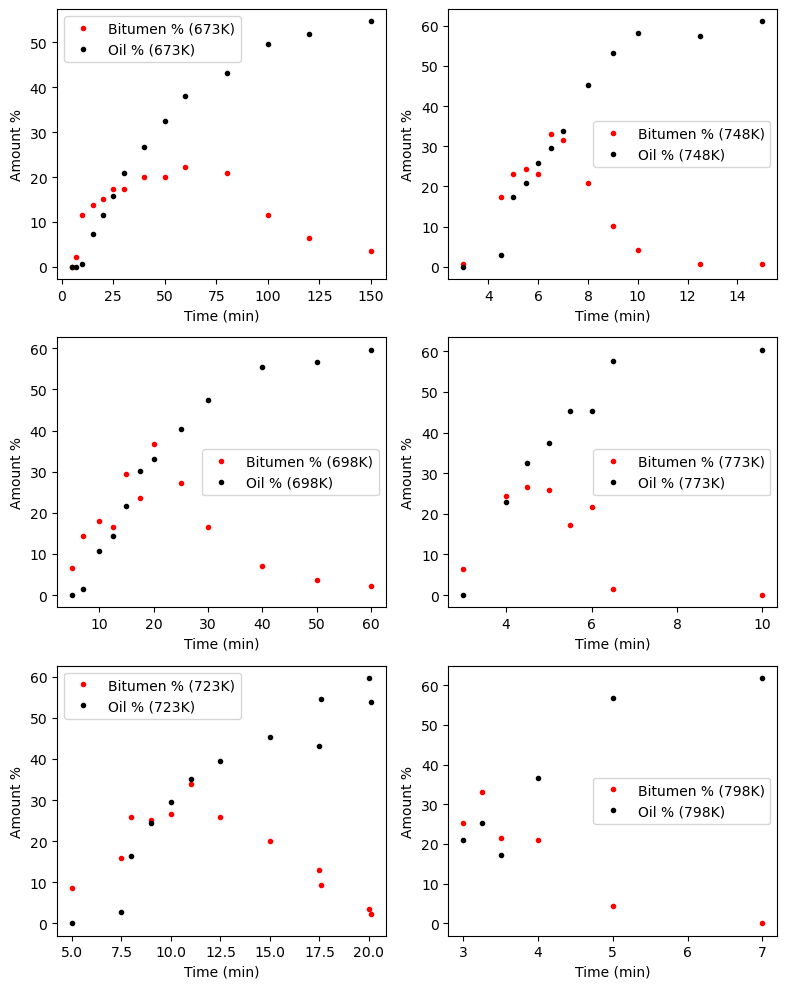

In [4]:
# plotting the two measured responses at 6 different temperatures
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (8, 10))

ax[0][0].plot(df1["time_673_K"], df1["Bitumen_673_K"], "r.", label = 'Bitumen % (673K)')
ax[0][0].plot(df1["time_673_K"], df1["Oil_673_K"], "k.", label = 'Oil % (673K)')
ax[0][0].set_xlabel("Time (min)")
ax[0][0].set_ylabel("Amount %")
ax[0][0].legend(["Bitumen % (673K)", 'Oil % (673K)'])

ax[1][0].plot(df2["time_698_K"], df2["Bitumen_698_K"], "r.", label = 'Bitumen % (698K)')
ax[1][0].plot(df2["time_698_K"], df2["Oil_698_K"], "k.", label = 'Oil % (698K)')
ax[1][0].set_xlabel("Time (min)")
ax[1][0].set_ylabel("Amount %")
ax[1][0].legend()

ax[2][0].plot(df3["time_723_K"], df3["Bitumen_723_K"], "r.", label = 'Bitumen % (723K)')
ax[2][0].plot(df3["time_723_K"], df3["Oil_723_K"], "k.", label = 'Oil % (723K)')
ax[2][0].set_xlabel("Time (min)")
ax[2][0].set_ylabel("Amount %")
ax[2][0].legend()

ax[0][1].plot(df4["time_748_K"], df4["Bitumen_748_K"], "r.", label = 'Bitumen % (748K)')
ax[0][1].plot(df4["time_748_K"], df4["Oil_748_K"], "k.", label = 'Oil % (748K)')
ax[0][1].set_xlabel("Time (min)")
ax[0][1].set_ylabel("Amount %")
ax[0][1].legend()

ax[1][1].plot(df5["time_773_K"], df5["Bitumen_773_K"], "r.", label = 'Bitumen % (773K)')
ax[1][1].plot(df5["time_773_K"], df5["Oil_773_K"], "k.", label = 'Oil % (773K)')
ax[1][1].set_xlabel("Time (min)")
ax[1][1].set_ylabel("Amount %")
ax[1][1].legend()

ax[2][1].plot(df6["time_798_K"], df6["Bitumen_798_K"], "r.", label = 'Bitumen % (798K)')
ax[2][1].plot(df6["time_798_K"], df6["Oil_798_K"], "k.", label = 'Oil % (798K)')
ax[2][1].set_xlabel("Time (min)")
ax[2][1].set_ylabel("Amount %")
ax[2][1].legend()

fig.tight_layout()

### Observations from the plots

One thing to note from these plots is that kerogen decomposition occurs more rapidly with increased temperature; at 673K there is a substantial fraction of bitumen after 100 min, but at 773K there is only a small fraction after 10 minutes which suggests that the rate constants depend on temperature.

A common form of rate constant dependence upon temperature is the **Arrhenius** relation:

$k_i(T) = k_{i,0}exp(\frac{-E_i}{RT})$

Estimating the **activation energies** and the **preexponential terms** usually results in high correlated estimates, since the range of the observed temperatures is small relative to the mean temperature. To reduce the correlations, we center the temperatures about an intermediate temperature T$_0$.

$k_i(T) = k_{i,0}exp(\frac{-E_i}{R}(\frac{1}{T}-\frac{1}{T_0})$

$lnk_i(T) = lnk_{i,0} - \frac{E_i}{R}(\frac{1}{T}-\frac{1}{T_0})=\phi_i - E_i\frac{1}{R}(\frac{1}{T}-\frac{1}{T_0})$

$lnk_i(T) = E_ix + \phi_i$

where E$_i$ arises from the values of the slope, while $\phi_i$ arises from the values of intercept

A linear kinetic model was proposed:

\begin{equation*} \frac{d \gamma_1}{dt} = -(\theta_1 + \theta_4)\gamma_1  \tag{1}\end{equation*}

\begin{equation*} \frac{d \gamma_2}{dt} = \theta_1\gamma_1 - (\theta_2 + \theta_3)\gamma_2 \tag{2}\end{equation*}

\begin{equation*} \frac{d \gamma_3}{dt} = \theta_4\gamma_1 + \theta_2\gamma_2 \tag{3}\end{equation*}

### Parameters as functions of other variables
In many situations, the parameters in a mechanistic model will depend on other variables. For example, in chemical kinetics studies, we may have data from several experiments in which the operating conditions have been varied, and it may be thought that the rate constants should depend in some systematic way on the operating conditions. We would then like to fit a model which incorporates and some process parameters, $\phi = (\phi_1,....\phi_L)^T$. That is, $\theta = \theta(w, \phi)$ The expectation function is the $f(x, \theta) = f(x, \theta(w, \phi))$.

To estimate the parameters in such an extended model, we could express the function in terms of the regular variables x, the process variables w, and the process parameters $\phi$.

*Note that for these data sets, only bitumen and oil have been measured at each time. The kerogen percentage is not measured, nor can it be inferred from a mass balance, since the by-products, coke and gas, are not measured either.*

However, we know that at time 0 the kerogen percentage is 100% while the percentages of the other species is zero at all tested temperatures. So an array of $[100, 0, 0]$ is going to be used as initial values for solving the ode system.

In [5]:
def ode_system(t, y, *params):
    
    a, b, c, d = params
    
    dy1 = -(a+d)*y[0]           # Kerogene
    dy2 = a*y[0] - (b+c)*y[1]   # Bitumen
    dy3 = d*y[0] + b*y[1]       # Oil
    
    return np.hstack([dy1, dy2, dy3])

*Note that regression function should only return the values of Bitumen & Oil since Kerogene is not measured and therefore is not included in the responses.*

In [6]:
def regres_fun(t, a, b, c, d):
    
    sol_ode = solve_ivp(ode_system, (t[0], t[-1]), [100, 0, 0],
                    args = (a, b, c, d), t_eval = t)
    
    return sol_ode.y[1:] # we return only the predicted values of Bitumen & Oil

### Fitting the individual temperature data

### calculate parameters at 673K

In [7]:
model = Model(regres_fun)

# set the boundries for each parameter
model.set_param_hint('a', min=0, max=np.inf)
model.set_param_hint('b', min=0, max=np.inf)
model.set_param_hint('c', min=0, max=np.inf)
model.set_param_hint('d', min=0, max=np.inf)


result_673 = model.fit(responses_673, t=regr_673, a=0.01, b=0.01, c=0.01, d=0.01)

print(result_673.fit_report())

best_values_673 = np.array(list(result_673.best_values.values()))
best_fit_673 = result_673.best_fit

[[Model]]
    Model(regres_fun)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 28
    # variables        = 4
    chi-square         = 99.0283791
    reduced chi-square = 4.12618246
    Akaike info crit   = 43.3696548
    Bayesian info crit = 48.6984728
    R-squared          = 0.98576278
[[Variables]]
    a:  0.01552383 +/- 0.00107129 (6.90%) (init = 0.01)
    b:  0.01007898 +/- 0.00177167 (17.58%) (init = 0.01)
    c:  0.01828833 +/- 0.00146605 (8.02%) (init = 0.01)
    d:  0.00887844 +/- 7.5182e-04 (8.47%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d) = -0.8729
    C(a, b) = +0.5163
    C(a, c) = +0.4010
    C(a, d) = -0.2483
    C(c, d) = +0.1327


### calculate parameters at 673K

*were are goint to use another loss function min_det for the sake of comparison min_det vs min_lsq*

In [8]:
def min_det(p, t, y, f):
    
    y_pred = f(t, *p)
    z = y_pred - y
    
    return np.linalg.det(z.dot(z.T))


initial_values = [0.01, 0.01, 0.01, 0.01]
bnds = ([0, np.inf], [0, np.inf], [0, np.inf], [0, np.inf])

min_sol_BFGS = minimize(min_det,
                            initial_values,
                            args=(regr_673, responses_673, regres_fun),
                            method="L-BFGS-B",
                            bounds = bnds)

min_sol_BFGS

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1532.7750776108874
        x: [ 1.564e-02  1.013e-02  1.842e-02  8.874e-03]
      nit: 19
      jac: [ 3.772e+00 -4.304e+00  5.801e+00 -2.307e+00]
     nfev: 115
     njev: 23
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

### Observations

The use of different loss function leads to the same convergence so lmfit is going to be used afterwards

### calculate parameters at 698K  and use the converged values of previous temperature (673K) as starting estimates for the 698K data set

In [9]:
result_698 = model.fit(responses_698, t=regr_698, a=best_values_673[0], b=best_values_673[1], 
                       c=best_values_673[2], d=best_values_673[3])

model.set_param_hint('a', min=0, max=np.inf)
model.set_param_hint('b', min=0, max=np.inf)
model.set_param_hint('c', min=0, max=np.inf)
model.set_param_hint('d', min=0, max=np.inf)

print(result_698.fit_report())

best_values_698 = np.array(list(result_698.best_values.values()))
best_fit_698 = result_698.best_fit

[[Model]]
    Model(regres_fun)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 24
    # variables        = 4
    chi-square         = 341.513060
    reduced chi-square = 17.0756530
    Akaike info crit   = 71.7279702
    Bayesian info crit = 76.4401855
    R-squared          = 0.95480938
[[Variables]]
    a:  0.06461607 +/- 0.00800299 (12.39%) (init = 0.01552383)
    b:  0.04429218 +/- 0.01006592 (22.73%) (init = 0.01007898)
    c:  0.04321384 +/- 0.00620871 (14.37%) (init = 0.01828833)
    d:  0.02122717 +/- 0.00544548 (25.65%) (init = 0.008878441)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d) = -0.9043
    C(a, b) = +0.5126
    C(a, c) = +0.4237
    C(a, d) = -0.3814
    C(b, c) = +0.2407


### calculate parameters at 723K  and use the converged values of previous temperature (698K) as starting estimates for the 723K data set

In [10]:
result_723 = model.fit(responses_723, t=regr_723, a=best_values_698[0], b=best_values_698[1], 
                       c=best_values_698[2], d=best_values_698[3])

model.set_param_hint('a', min=0, max=np.inf)
model.set_param_hint('b', min=0, max=np.inf)
model.set_param_hint('c', min=0, max=np.inf)
model.set_param_hint('d', min=0, max=np.inf)

print(result_723.fit_report())

best_values_723 = np.array(list(result_723.best_values.values()))
best_fit_723 = result_723.best_fit

[[Model]]
    Model(regres_fun)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 24
    # variables        = 4
    chi-square         = 531.107486
    reduced chi-square = 26.5553743
    Akaike info crit   = 82.3258542
    Bayesian info crit = 87.0380695
    R-squared          = 0.92409421
[[Variables]]
    a:  0.16949656 +/- 0.02669656 (15.75%) (init = 0.06461607)
    b:  0.12973742 +/- 0.03511818 (27.07%) (init = 0.04429218)
    c:  0.11694427 +/- 0.02012791 (17.21%) (init = 0.04321384)
    d:  0.04376724 +/- 0.01877082 (42.89%) (init = 0.02122717)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d) = -0.9370
    C(a, c) = +0.4191
    C(a, b) = +0.4135
    C(a, d) = -0.3733
    C(c, d) = +0.1036


### calculate parameters at 748K  and use the converged values of previous temperature (723K) as starting estimates for the 748K data set

In [11]:
result_748 = model.fit(responses_748, t=regr_748, a=best_values_723[0], b=best_values_723[1], 
                       c=best_values_723[2], d=best_values_723[3])

model.set_param_hint('a', min=0, max=np.inf)
model.set_param_hint('b', min=0, max=np.inf)
model.set_param_hint('c', min=0, max=np.inf)
model.set_param_hint('d', min=0, max=np.inf)

print(result_748.fit_report())

best_values_748 = np.array(list(result_748.best_values.values()))
best_fit_748 = result_748.best_fit

[[Model]]
    Model(regres_fun)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 24
    # variables        = 4
    chi-square         = 469.689382
    reduced chi-square = 23.4844691
    Akaike info crit   = 79.3764261
    Bayesian info crit = 84.0886415
    R-squared          = 0.94520501
[[Variables]]
    a:  0.32673906 +/- 0.05668150 (17.35%) (init = 0.1694966)
    b:  0.37761905 +/- 0.09721511 (25.74%) (init = 0.1297374)
    c:  0.19511873 +/- 0.03379116 (17.32%) (init = 0.1169443)
    d:  0.01080644 +/- 0.04322887 (400.03%) (init = 0.04376724)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d) = -0.9520
    C(a, d) = -0.7301
    C(a, b) = +0.6281
    C(a, c) = +0.4916
    C(b, c) = +0.1816
    C(c, d) = -0.1342


### calculate parameters at 773K  and use the converged values of previous temperature (748K) as starting estimates for the 773K data set

In [12]:
result_773 = model.fit(responses_773, t=regr_773, a=best_values_748[0], b=best_values_748[1], 
                       c=best_values_748[2], d=best_values_748[3])

model.set_param_hint('a', min=0, max=np.inf)
model.set_param_hint('b', min=0, max=np.inf)
model.set_param_hint('c', min=0, max=np.inf)
model.set_param_hint('d', min=0, max=np.inf)

print(result_773.fit_report())

best_values_773 = np.array(list(result_773.best_values.values()))
best_fit_773 = result_773.best_fit

[[Model]]
    Model(regres_fun)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 16
    # variables        = 4
    chi-square         = 247.805119
    reduced chi-square = 20.6504266
    Akaike info crit   = 51.8408625
    Bayesian info crit = 54.9312174
    R-squared          = 0.95519573
[[Variables]]
    a:  0.63136801 +/- 0.14401750 (22.81%) (init = 0.3267391)
    b:  0.42105518 +/- 0.15455786 (36.71%) (init = 0.377619)
    c:  0.45075823 +/- 0.07124519 (15.81%) (init = 0.1951187)
    d:  0.21431638 +/- 0.08955086 (41.78%) (init = 0.01080644)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d) = -0.9482
    C(a, b) = +0.5936
    C(a, d) = -0.4956
    C(a, c) = +0.3190
    C(b, c) = +0.1062


### calculate parameters at 798K  and use the converged values of previous temperature (773K) as starting estimates for the 798K data set

In [13]:
result_798 = model.fit(responses_798, t=regr_798, a=best_values_773[0], b=best_values_773[1], 
                       c=best_values_773[2], d=best_values_773[3])

model.set_param_hint('a', min=0, max=np.inf)
model.set_param_hint('b', min=0, max=np.inf)
model.set_param_hint('c', min=0, max=np.inf)
model.set_param_hint('d', min=0, max=np.inf)

print(result_798.fit_report())

best_values_798 = np.array(list(result_798.best_values.values()))
best_fit_798 = result_798.best_fit

[[Model]]
    Model(regres_fun)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 12
    # variables        = 4
    chi-square         = 1455.33306
    reduced chi-square = 181.916633
    Akaike info crit   = 65.5770010
    Bayesian info crit = 67.5166276
    R-squared          = 0.60440185
[[Variables]]
    a:  1.63933066 +/- 0.96449783 (58.83%) (init = 0.631368)
    b:  0.97363919 +/- 1.09369045 (112.33%) (init = 0.4210552)
    c:  1.07811614 +/- 0.63122041 (58.55%) (init = 0.4507582)
    d:  0.45931048 +/- 0.64728985 (140.93%) (init = 0.2143164)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, d) = -0.8963
    C(a, b) = +0.5571
    C(b, c) = +0.4578
    C(a, d) = -0.4126
    C(a, c) = +0.3457
    C(c, d) = -0.2188


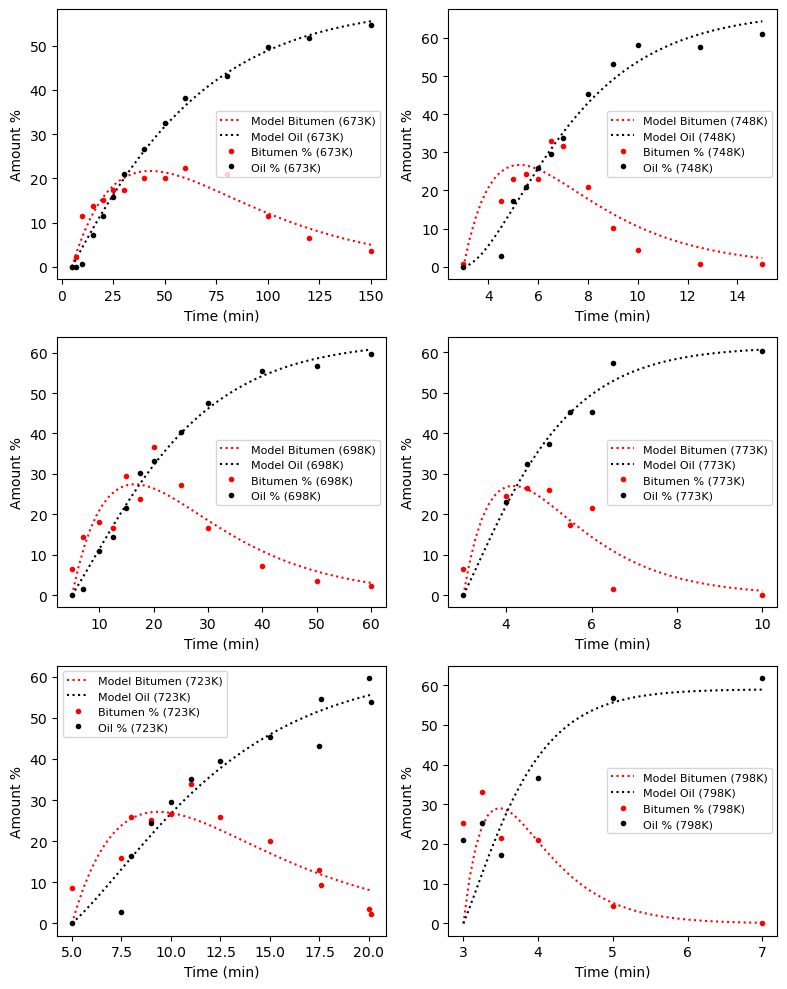

In [14]:
# plotting the two measured responses at 6 different temperatures
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (8, 10))

###########################################################################################################
# predicted values at 673K
x_673_fit = np.linspace(min(df1["time_673_K"]), max(df1["time_673_K"]), 50)
ax[0][0].plot(x_673_fit, regres_fun(x_673_fit, *best_values_673)[0], "r:", label = 'Model Bitumen (673K)')
ax[0][0].plot(x_673_fit, regres_fun(x_673_fit, *best_values_673)[1], "k:", label = 'Model Oil (673K)')

# responses at # responses at 673K
ax[0][0].plot(df1["time_673_K"], df1["Bitumen_673_K"], "r.", label = 'Bitumen % (673K)')
ax[0][0].plot(df1["time_673_K"], df1["Oil_673_K"], "k.", label = 'Oil % (673K)')

# x,y axis info
ax[0][0].set_xlabel("Time (min)")
ax[0][0].set_ylabel("Amount %")
ax[0][0].legend(fontsize = 8)

###########################################################################################################
# predicted values at 698K
x_698_fit = np.linspace(min(df2["time_698_K"]), max(df2["time_698_K"]), 50)
ax[1][0].plot(x_698_fit, regres_fun(x_698_fit, *best_values_698)[0], "r:", label = 'Model Bitumen (698K)')
ax[1][0].plot(x_698_fit, regres_fun(x_698_fit, *best_values_698)[1], "k:", label = 'Model Oil (698K)')

# responses at # responses at 698K
ax[1][0].plot(df2["time_698_K"], df2["Bitumen_698_K"], "r.", label = 'Bitumen % (698K)')
ax[1][0].plot(df2["time_698_K"], df2["Oil_698_K"], "k.", label = 'Oil % (698K)')

# x,y axis info
ax[1][0].set_xlabel("Time (min)")
ax[1][0].set_ylabel("Amount %")
ax[1][0].legend(fontsize = 8)

###########################################################################################################
# predicted values at 723K
x_723_fit = np.linspace(min(df3["time_723_K"]), max(df3["time_723_K"]), 50)
ax[2][0].plot(x_723_fit, regres_fun(x_723_fit, *best_values_723)[0], "r:", label = 'Model Bitumen (723K)')
ax[2][0].plot(x_723_fit, regres_fun(x_723_fit, *best_values_723)[1], "k:", label = 'Model Oil (723K)')

# responses at # responses at 723K
ax[2][0].plot(df3["time_723_K"], df3["Bitumen_723_K"], "r.", label = 'Bitumen % (723K)')
ax[2][0].plot(df3["time_723_K"], df3["Oil_723_K"], "k.", label = 'Oil % (723K)')

# x,y axis info
ax[2][0].set_xlabel("Time (min)")
ax[2][0].set_ylabel("Amount %")
ax[2][0].legend(fontsize = 8)

###########################################################################################################
# predicted values at 748K
x_748_fit = np.linspace(min(df4["time_748_K"]), max(df4["time_748_K"]), 50)
ax[0][1].plot(x_748_fit, regres_fun(x_748_fit, *best_values_748)[0], "r:", label = 'Model Bitumen (748K)')
ax[0][1].plot(x_748_fit, regres_fun(x_748_fit, *best_values_748)[1], "k:", label = 'Model Oil (748K)')

# responses at # responses at 773K
ax[0][1].plot(df4["time_748_K"], df4["Bitumen_748_K"], "r.", label = 'Bitumen % (748K)')
ax[0][1].plot(df4["time_748_K"], df4["Oil_748_K"], "k.", label = 'Oil % (748K)')

# x,y axis info
ax[0][1].set_xlabel("Time (min)")
ax[0][1].set_ylabel("Amount %")
ax[0][1].legend(fontsize = 8)

###########################################################################################################
# predicted values at 773K
x_773_fit = np.linspace(min(df5["time_773_K"]), max(df5["time_773_K"]), 50)
ax[1][1].plot(x_773_fit, regres_fun(x_773_fit, *best_values_773)[0], "r:", label = 'Model Bitumen (773K)')
ax[1][1].plot(x_773_fit, regres_fun(x_773_fit, *best_values_773)[1], "k:", label = 'Model Oil (773K)')

# responses at 773K
ax[1][1].plot(df5["time_773_K"], df5["Bitumen_773_K"], "r.", label = 'Bitumen % (773K)')
ax[1][1].plot(df5["time_773_K"], df5["Oil_773_K"], "k.", label = 'Oil % (773K)')

# x,y axis info
ax[1][1].set_xlabel("Time (min)")
ax[1][1].set_ylabel("Amount %")
ax[1][1].legend(fontsize = 8)

###########################################################################################################
# predicted values at 798K
x_798_fit = np.linspace(min(df6["time_798_K"]), max(df6["time_798_K"]), 50)
ax[2][1].plot(x_798_fit, regres_fun(x_798_fit, *best_values_798)[0], "r:", label = 'Model Bitumen (798K)')
ax[2][1].plot(x_798_fit, regres_fun(x_798_fit, *best_values_798)[1], "k:", label = 'Model Oil (798K)')

# responses at 798K
ax[2][1].plot(df6["time_798_K"], df6["Bitumen_798_K"], "r.", label = 'Bitumen % (798K)')
ax[2][1].plot(df6["time_798_K"], df6["Oil_798_K"], "k.", label = 'Oil % (798K)')

# x,y axis info
ax[2][1].set_xlabel("Time (min)")
ax[2][1].set_ylabel("Amount %")
ax[2][1].legend(fontsize = 8)

fig.tight_layout()

### Fitting the complete dataset

In [15]:
# estimated parameters
estimated_params = np.vstack([best_values_673, best_values_698, best_values_723, 
                              best_values_748, best_values_773, best_values_798])

estimated_params

array([[0.01552383, 0.01007898, 0.01828833, 0.00887844],
       [0.06461607, 0.04429218, 0.04321384, 0.02122717],
       [0.16949656, 0.12973742, 0.11694427, 0.04376724],
       [0.32673906, 0.37761905, 0.19511873, 0.01080644],
       [0.63136801, 0.42105518, 0.45075823, 0.21431638],
       [1.63933066, 0.97363919, 1.07811614, 0.45931048]])

In [16]:
# we are going to use the exact average temperature instead of 723K that is used in the example
T_tested = np.array([673, 698, 723, 748, 773, 798])
T_avg = np.mean(673 + 698 + 723 + 748 + 773 + 798)/len(T_tested)
T_avg

735.5

$T_{inv}= \frac{-1000}{R}(\frac{1}{T}-\frac{1}{T_{avg}})$ where 1000 is a factor to convert cal to kcal

In [17]:
T_inv = lambda T: -1000/1.987*(1/T - 1/T_avg)

xaxis = T_inv(T_tested)

In [18]:
final_matrix = np.vstack([xaxis, np.log(estimated_params).T])

pd.DataFrame(final_matrix.T, columns = ["T_inv", "lnθ1", "lnθ2", "lnθ3", "lnθ4"])

,T_inv,lnθ1,lnθ2,lnθ3,lnθ4
0,-0.063545,-4.165379,-4.597303,-4.001492,-4.724129
1,-0.036762,-2.739292,-3.116947,-3.141595,-3.852473
2,-0.011830,-1.774923,-2.042243,-2.146058,-3.128870
3,0.011435,-1.118593,-0.973869,-1.634147,-4.527613
4,0.033195,-0.459866,-0.864991,-0.796824,-1.540302
5,0.053592,0.494288,-0.026714,0.075215,-0.778029


In [19]:
from scipy import stats

def lin_reg(x, y):

    slope, intercept, r, p, std_err = stats.linregress(x, y)
    
    return list(map(lambda x: slope*x + intercept, x))

ln_θ = []
for arr in final_matrix[1:]:
    ln_θ.append(lin_reg(xaxis, arr))

ln_θ = np.array(ln_θ)
ln_θ

array([[-3.93672002, -2.92644634, -1.98603945, -1.10849397, -0.28771082,
         0.48164482],
       [-4.24942048, -3.23784169, -2.29621993, -1.41754081, -0.59569733,
         0.17465219],
       [-4.02619347, -3.11393151, -2.26475821, -1.47234783, -0.73119297,
        -0.03647639],
       [-4.94880401, -4.13649012, -3.38035286, -2.67475953, -2.01480613,
        -1.39620319]])

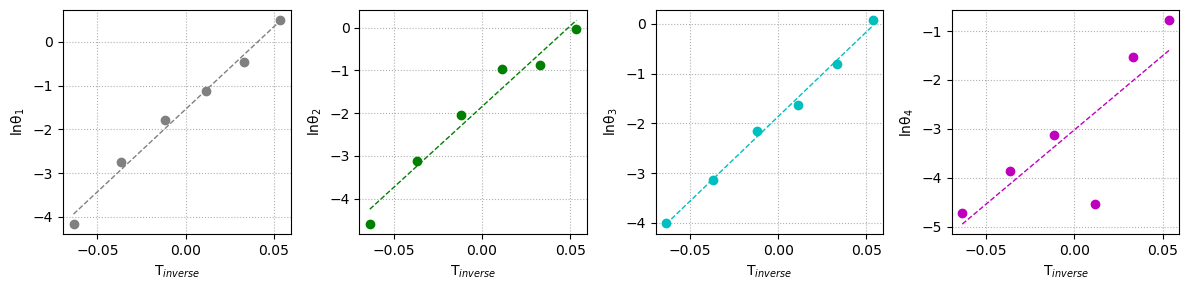

In [20]:
# plots of kinetic parameter estimates and Arrhenius model fits for the oil shale data
fig, ax = plt.subplots(ncols = 4, figsize = (12, 3))
col = ["grey", "green", "c", "m"]
lab = ["lnθ$_1$", "lnθ$_2$", "lnθ$_3$", "lnθ$_4$"]

for j, arr in enumerate(ln_θ):
    
    ax[j].plot(xaxis, final_matrix[j+1], "o", color = col[j], lw = 1)
    ax[j].plot(xaxis, lin_reg(xaxis, arr), "--", color = col[j], lw = 1)
    ax[j].set_ylabel("{}".format(lab[j]))
    ax[j].set_xlabel('T$_{inverse}$')
    ax[j].grid(linestyle = ":")

fig.tight_layout()

### Create a reduced matrix

*We are going to remove the 4th column of the final_matrix in order to improve the linear relationship*

In [21]:
final_matrix

array([[-0.06354544, -0.03676168, -0.01183018,  0.01143478,  0.03319489,
         0.05359158],
       [-4.16537924, -2.73929214, -1.77492265, -1.11859342, -0.45986637,
         0.49428803],
       [-4.59730284, -3.11694721, -2.04224273, -0.9738694 , -0.86499139,
        -0.02671448],
       [-4.00149202, -3.14159457, -2.14605781, -1.63414705, -0.79682415,
         0.0752152 ],
       [-4.72412932, -3.85247318, -3.12886967, -4.52761286, -1.54030193,
        -0.77802888]])

In [22]:
reduced_matrix = np.delete(final_matrix, 3, axis=1)

In [23]:
reduced_matrix

array([[-0.06354544, -0.03676168, -0.01183018,  0.03319489,  0.05359158],
       [-4.16537924, -2.73929214, -1.77492265, -0.45986637,  0.49428803],
       [-4.59730284, -3.11694721, -2.04224273, -0.86499139, -0.02671448],
       [-4.00149202, -3.14159457, -2.14605781, -0.79682415,  0.0752152 ],
       [-4.72412932, -3.85247318, -3.12886967, -1.54030193, -0.77802888]])

In [24]:
x_axis_reduced = reduced_matrix[0]

In [25]:
lnθ_reduced = []

for arr in reduced_matrix[1:]:
    lnθ_reduced.append(lin_reg(x_axis_reduced, arr))
    
lnθ_reduced = np.array(lnθ_reduced)
lnθ_reduced

array([[-3.93573987, -2.92498995, -1.98413976, -0.28501055,  0.48470775],
       [-4.29247911, -3.3018214 , -2.3796739 , -0.71432085,  0.0400966 ],
       [-4.01049074, -3.09059923, -2.23432401, -0.68793305,  0.01259368],
       [-4.76898327, -3.8692991 , -3.03183376, -1.51941252, -0.83427433]])

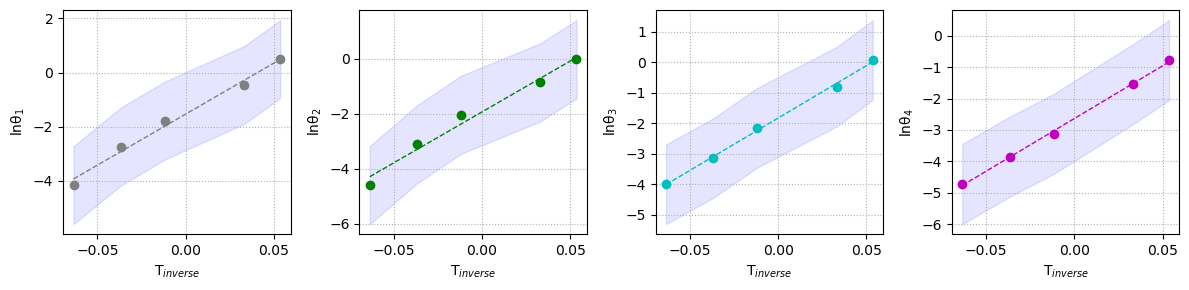

In [26]:
# plots of kinetic parameter estimates and Arrhenius model fits for the oil shale data
fig, ax = plt.subplots(ncols = 4, figsize = (12, 3))
col = ["grey", "green", "c", "m"]
lab = ["lnθ$_1$", "lnθ$_2$", "lnθ$_3$", "lnθ$_4$"]

for j, arr in enumerate(lnθ_reduced):
    
    ax[j].plot(x_axis_reduced, reduced_matrix[j+1], "o", color = col[j], lw = 1)
    ax[j].plot(x_axis_reduced, lin_reg(x_axis_reduced, arr), "--", color = col[j], lw = 1)
    
    # 95% confidence intervals
    conf_int = 1.96 * np.std(reduced_matrix[j+1])/np.sqrt(len(x_axis_reduced))
    ax[j].fill_between(x_axis_reduced, (reduced_matrix[j+1]-conf_int), (reduced_matrix[j+1]+conf_int), color='b', alpha=.1)
    
    ax[j].set_ylabel("{}".format(lab[j]))
    ax[j].set_xlabel('T$_{inverse}$')
    ax[j].grid(linestyle = ":")

fig.tight_layout()

In [27]:
def linear_params(x, y):

    slope, intercept, r, p, std_err = stats.linregress(x, y)
    
    return np.array([slope, intercept, std_err])

lin_params = []
for arr in reduced_matrix[1:]:
    lin_params.append(linear_params(x_axis_reduced, arr))

params_matrix = np.array(lin_params)

pd.DataFrame(params_matrix, 
             columns = ["slope", "intercept", "standard error"], 
             index = ["θ1", "θ2", "θ3", "θ4"])

,slope,intercept,standard error
θ1,37.737407,-1.537700,2.397474
θ2,36.987244,-1.942108,3.087616
θ3,34.345114,-1.828015,0.966122
θ4,33.590651,-2.634450,0.737833


In [28]:
params_matrix

array([[37.73740722, -1.53769962,  2.39747356],
       [36.98724387, -1.94210833,  3.08761636],
       [34.34511351, -1.8280153 ,  0.96612208],
       [33.59065106, -2.63445048,  0.7378326 ]])

### Values of the Kinetic Parameters Derived from the Estimation Based on the Data at All Temperatures

In [29]:
final_df = pd.DataFrame(params_matrix[:, :-1], 
             columns = ["E_i in (kcal/mol/k)", "intercept"], index = ["θ1", "θ2", "θ3", "θ4"])

final_df["k_i0"] = np.exp(final_df["intercept"])

final_df

,E_i in (kcal/mol/k),intercept,k_i0
θ1,37.737407,-1.537700,0.214875
θ2,36.987244,-1.942108,0.143401
θ3,34.345114,-1.828015,0.160732
θ4,33.590651,-2.634450,0.071758


### Observations

The estimated parameters are very close to the ones calculated by Bates and Watts. 

*Note that the authors adopted the generalized gauss-newton method with the determinant loss function.*

In [30]:
# calculated values from Bates and Watts
df_Bates_Watts = pd.DataFrame()

df_Bates_Watts["E_i in (kcal/mol/k)"] = [38.14, 34.25, 34.41, 36.13]
df_Bates_Watts["intercept"] = [-1.920, -2.277, -2.195, -3.024]
df_Bates_Watts["k_i0"] = np.exp(df_Bates_Watts["intercept"])

df_Bates_Watts

,E_i in (kcal/mol/k),intercept,k_i0
0,38.14,-1.920,0.146607
1,34.25,-2.277,0.102592
2,34.41,-2.195,0.111359
3,36.13,-3.024,0.048606
